# Building Autoencoders in ~~Keras~~ PyTorch

WNixalo – 2018/6/16

[Building Autoencoders in Keras](https://blog.keras.io/building-autoencoders-in-keras.html)

In [223]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [222]:
import numpy as np
import torch

In [99]:
import matplotlib.pyplot as plt

In [2]:
import copy

## 1. Building the simplest possible autoencoder

> We'll start simple, with a single fully-connected neural layer as encoder and as decoder:

```
from keras.layers import Input, Dense
from keras.models import Model

# this is the size of our encoded representations
encoding_dim = 32 # 32 floats -> compression of factor 24.5 assuming input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)
```

In [12]:
import torch.nn as nn
import torch.nn.functional as F

In [13]:
# # encoding size
# encoding_dim = 32

# # input placeholder
# input_img = torch.tensor(torch.rand(784), requires_grad=True) # I guess should have grad?
# # the encoded representation of input
# encoded = nn.ModuleList([nn.Linear(784, encoding_dim), nn.ReLU()])
# # the lossy reconstruction of the input
# decoded = nn.ModuleList([nn.Linear(encoding_dim, 784), nn.Sigmoid()])

# # this model maps an input to its reconstruction
# autoencoder = nn.Sequential(encoded, decoded)

> Let's also create a separate encoder model:

```
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)
```
> As well as the decoder model:

```
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))
```

In [34]:
# # model maps an input to its encoded representation
# encoder = copy.deepcopy(encoded) # copying models: https://discuss.pytorch.org/t/copying-nn-modules-without-shared-memory/113/2

# # placeholder for 32-dim encoded input
# encoded_input = torch.tensor(torch.rand(784), requires_grad=True)
# # retrieve last layer of autoencoder model
# decoder_layer = list(autoencoder.children())[-1]
# # create decoder model
# decoder = copy.deepcopy(decoder_layer)

In [4]:
input_size   = 784
encoding_dim = 32

In [193]:
# writing full classes for the en/de-coders is overkill, but this is the 
# general form of writing pytorch modules.

class Encoder(nn.Module):
    def __init__(self, input_size, encoding_dim):
        super().__init__()
        self.layers = nn.ModuleList([nn.Linear(input_size, encoding_dim), nn.ReLU()])
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
            
class Decoder(nn.Module):
    def __init__(self, encoding_dim, input_size):
        super().__init__()
        self.layers = nn.ModuleList([nn.Linear(encoding_dim, input_size)])
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

class Autoencoder(nn.Module):
    def __init__(self, input_size=784, encoding_dim=32):
        super().__init__()
        self.encoder = Encoder(input_size, encoding_dim)
        self.decoder = Decoder(encoding_dim, input_size)
    def forward(self, x):
        x = x.view(x.size(0), -1) # flatten to (nm,1) vector
        x = self.encoder(x)  # Encode
        x = self.decoder(x)  # Decode
        x = F.sigmoid(x)
        x = x.reshape(x.size(0),1,28,28) # should be a more elegant way to do this
        return x

Autoencoder without any training (you'd expect just noise):

In [204]:
autoencoder = Autoencoder(784, 32)

In [195]:
x,y = next(iter(train_loader))
z = autoencoder(x)

In [196]:
z.shape

torch.Size([16, 1, 28, 28])

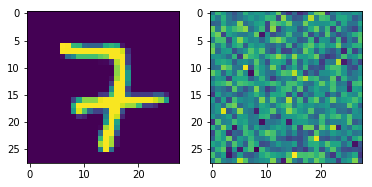

In [197]:
fig,axes = plt.subplots(1,2); plt.set_cmap(['gray','viridis'][1]);
axes[0].imshow(x[0][0].numpy()); axes[1].imshow(z[0][0].detach().numpy());

> Now let's train our autoencoder to reconstruct MNIST digits.
>
> First, we'll configure our model to use a per-pixel binary crossentropy loss, and the Adadelta optimizer:

```
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
```

> Let's prepare our input data. We're using MNIST digits, and we're discarding the labels (since we're only interested in encoding/decoding the input images).

```
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()
```

> We will normalize all values between 0 and 1 and we will flatten the 28x28 images into vectors of size 784.

```
x_train = x_train.astype('float32') / 255.
x_test  = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test  = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)
```

In [166]:
# these are actually initialized within the training loop
optimizer = torch.optim.Adadelta(autoencoder.parameters())
criterion = torch.nn.BCELoss()

In [167]:
import torchvision

In [168]:
bs = 16

# stats = [[0.1307],[0.3073]]

tfm0 = torchvision.transforms.ToTensor()  # convert [0,255] -> [0.0,1.0]
# tfm1 = torchvision.transforms.Normalize(*stats) # normalize to [-1.0,+1.0]

# tfms = [tfm0, tfm1]
# tfms = torchvision.transforms.Compose(tfms)

In [169]:
train_dataset = torchvision.datasets.MNIST('data/MNIST/',train=True, transform=tfm0)
test_dataset  = torchvision.datasets.MNIST('data/MNIST/',train=False,transform=tfm0)

train_loader  = torch.utils.data.DataLoader(train_dataset, batch_size=bs, shuffle=True)
test_loader   = torch.utils.data.DataLoader(test_dataset,  batch_size=bs)

multiple ways to flatten tensors:

In [170]:
# get minibatch
x,_ = next(iter(train_loader)); x_test,_ = next(iter(test_loader))
# check ea. way to flatten is identical
compare0 = torch.equal(np.reshape(x, (len(x), np.prod(x.shape[1:]))),
                       x.reshape(len(x), np.prod(x.shape[1:])))
compare1 = torch.equal(x.view(x.size(0), -1), x.reshape(len(x), np.prod(x.shape[1:])))
print(True == compare0 == compare1)
# display flattened minibatch shapes
print(x.view(x.size(0), -1).shape)
print(x_test.view(x_test.size(0), -1).shape)

True
torch.Size([16, 784])
torch.Size([16, 784])


I'll just flatten each minibatch as it comes out of the dataloader when I'm using the model.

> Now let's train our autoencoder for 50 epochs:

```
autoencoder.fit(x_train, x_train, epochs=50, batch_size=256, shuffle=True,
                validation_data=(x_test, x_test))
```

> After 50 epochs, the autoencoder seems to reach a stable train/test loss value of about `0.11`. We can try to visualize the reconstrubted inputs and the encoded representations. We will use Matplotlib.

```
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)
```

```
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10 # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
```

In [203]:
def train(model, trainloader=None, valloader=None, num_epochs=1):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    
    # name dataloaders for phases
    phases = ['train']
    dataloaders = {'train':trainloader}
    if valloader:
        phases.append('valid')
        dataloaders['valid'] = valloader
    
    # move model to gpu -- pytorch >= 0.4 ## NOTE: havent tested on gpu yet
    model.to(device)
    optimizer = torch.optim.Adadelta(autoencoder.parameters())
    criterion = torch.nn.BCELoss()
    
    # epoch w/ train & val phases
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}\n{"-"*10}')
        
        for phase in phases:
            if phase == 'train':
                #scheduler.step() # (no LR scheduler this time)
                model.train() # set model to training mode
            else: model.eval() # set model to evaluation mode
                
            running_loss, running_correct, count = 0.0, 0, 0
        
            for i, minibatch in enumerate(dataloaders[phase]):
                x,y = minibatch
                x,y = x.to(device), y.to(device)

                # zero param gradients
                optimizer.zero_grad()

                # forward: track history if training phase
                with torch.set_grad_enabled(phase=='train'): # pytorch >= 0.4
                    outputs = model(x)
                    loss    = criterion(outputs, x)
#                     pdb.set_trace()
                    preds,_ = torch.max(outputs,1) # for accuracy metric
                    # backward & optimize if training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # stats
                running_loss += loss.item() * x.size(0)
                running_correct += torch.sum(preds == x.data)
                count += len(x)
            
            epoch_loss = running_loss / count
            epoch_acc  = running_correct.double() / count
            
            # (not doing this here) deep copy model if best so far
            #if phase == 'val' and epoch_acc > best_acc:
            #    best_acc = epoch_acc
            #    best_model_wts = copy.deepcopy(model.state_dict())
            
            

In [205]:
%time train(autoencoder, trainloader=train_loader, valloader=test_loader, num_epochs=1)

Epoch 1/1
----------
CPU times: user 54.4 s, sys: 1.3 s, total: 55.7 s
Wall time: 19.7 s


In [208]:
z = autoencoder(x)

In [210]:
def compare_plot(x,z, idx=0, cdx=1):
    """assumes x,y (bs,1,28,28) tensors"""
    fig,axes = plt.subplots(1,2); plt.set_cmap(['gray','viridis'][cdx]);
    axes[0].imshow(x[idx][0].numpy()); axes[1].imshow(z[idx][0].detach().numpy());

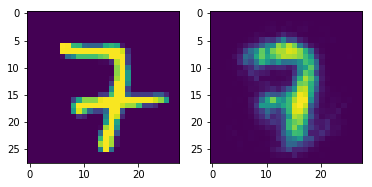

In [211]:
compare_plot(x,z)

Woah.

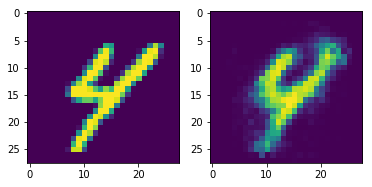

In [212]:
compare_plot(x,z,idx=1)

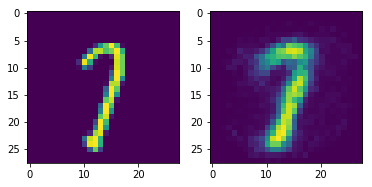

In [213]:
compare_plot(x,z,idx=2)

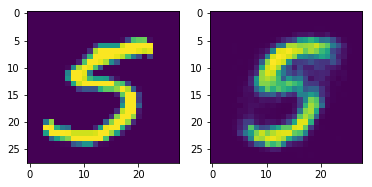

In [214]:
compare_plot(x,z,idx=3)

## 2. Adding a sparsity constraint on the encoded representations

## 3. Deep autoencoder

## 4. Convolutional autoencoder

## 5. Application to image denoising

## 6. Sequence–to–sequence autoencoder

## 7. Variational autoencoder (VAE)

---

### Aside: calculating μ & σ of MNIST

I wanted some values to normalize the dataset with. I did this by only passing in the `ToTensor()` transfor to the dataset object and turning off shuffling (though that shouldn't matter), then computing the standard deviation & mean.

On second look, FChollet only normalizes to between `[0.0,1.0]`, so this was unnecessary.

In [99]:
%%time
std,mean,count = 0.,0.,0
for x,_ in train_loader:
    std   += torch.std(x)
    mean  += torch.mean(x)
    count += 1
std  /= count
mean /= count

CPU times: user 4.82 s, sys: 17.3 ms, total: 4.84 s
Wall time: 4.86 s


In [100]:
std, mean

(tensor(0.3073), tensor(0.1307))

---